In [2]:
%pip install chronos-forecasting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 1.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.8/150.8 MB 9.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 19.9 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.8/447.8 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 23.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.6/179.6 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 27.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 31.5 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0

[notice] A new release of pip i

In [22]:
import pandas as pd  # requires: pip install pandas
import torch
import numpy as np
from chronos import BaseChronosPipeline

In [28]:
df = pd.read_csv('../src/static/IEA-EV-dataEV-salesHistoricalCars.csv')
df['year'] = pd.to_datetime(df['year'], format='%Y')
df = df.dropna()
df = df[df["parameter"] == "Oil displacement, million lge"][['year','value']]
df = df.groupby(['year']).mean().reset_index()

In [31]:
train_data = df.iloc[:-5]
test_data = df.iloc[-5:]

In [18]:
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",  # use "amazon/chronos-bolt-small" for the corresponding Chronos-Bolt model
    device_map="cpu",  # use "cpu" for CPU inference
    torch_dtype=torch.bfloat16,
)

In [34]:
quantiles, mean = pipeline.predict_quantiles(
    context=torch.tensor(train_data["value"].to_numpy()),
    prediction_length=5,
    quantile_levels=[0.1, 0.5, 0.9],
)

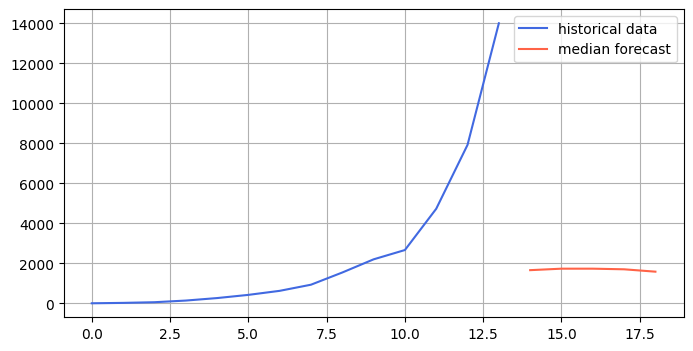

In [36]:
import matplotlib.pyplot as plt  # requires: pip install matplotlib

forecast_index = range(len(df), len(df) + 5)
low, median, high = quantiles[0, :, 0], quantiles[0, :, 1], quantiles[0, :, 2]

plt.figure(figsize=(8, 4))
plt.plot(df["value"].to_numpy(), color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.legend()
plt.grid()
plt.show()

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

true_values = test_data["value"].to_numpy()
predicted_values = median
mse = mean_squared_error(true_values, predicted_values)
mae = mean_absolute_error(true_values, predicted_values)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 40626139.48194729
Mean Absolute Error (MAE): 4622.492032877604
